In [9]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, e, log, isclose, exp
from scipy.optimize import minimize,basinhopping

We already *know* what the shape of each particle's curve given a q and fres should look like, it's just 1/ f-fres^2 - just sum each contribution, envelope, with basinhopper

Relaxation time might itself change with freq.

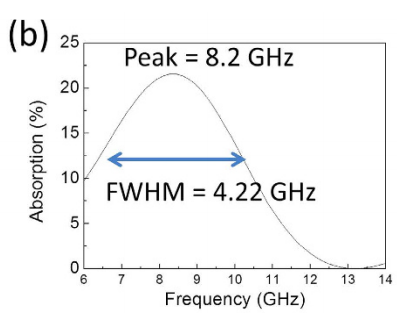

This problem has a long history, stretching back to Cole-Cole's landmark paper in 1942

The curve is called "the Lorentzian". 

This field is also called "Multivariate curve resolution" or 

Assuming that the resonant frequency and Q factor distributions are gaussian, we fit the gaussian average and std. dev. of each. We also have to fit the covariance of Q with w0.

Digitized with engauge digitizer

In [2]:
curve_file = "../biology/data/figure_6a_Yang_digitized.csv"
curve = np.genfromtxt(open(curve_file, "r"), delimiter=",", dtype=np.float, encoding='ascii', skip_header=1)

curve[:,0] *= 1e9
curve[:,1] = curve[:,1] / np.max(curve[:,1]) #normalize


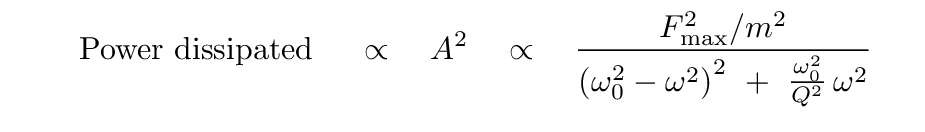

from http://spiff.rit.edu/classes/phys283/lectures/forced_ii/forced_ii.html

(careful now! power vs amplitude! might have made a mistake here, re-check later!) 

$$\omega_r = \omega_0 \sqrt{1 - 2\zeta^2}$$

where $\zeta = \frac{1}{2 Q}$

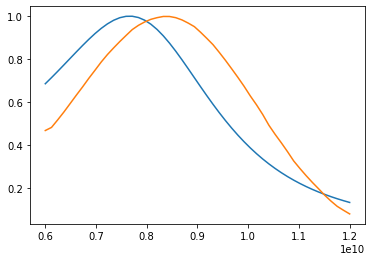

In [3]:
Q = 1.95
f_res = 8.22e9

def power_absorption_curve(f_res, Q, frequencies):
    # M and Fmax 
    angular_freq_res = 2.0*pi*f_res
    angular_frequencies = 2.0*pi*frequencies
    term_1 = ((angular_freq_res**2.0 - angular_frequencies**2.0)**2.0)
    term_2 = ((angular_freq_res**2.0)/(Q**2.0)) * (angular_frequencies**2.0)
        
    curve = 1/(term_1 + term_2)
    curve = curve / np.max(curve) #normalize

    
    return curve
    
frequencies = np.linspace(6e9, 12e9)
simple_curve = power_absorption_curve(f_res, Q, frequencies)
plt.plot(frequencies,simple_curve)

interp_Yang_curve = np.interp(frequencies, curve[:,0], curve[:,1]) # linterp the hand-drawn points to match up with the freqs

plt.plot(frequencies,interp_Yang_curve)


In [60]:

def sample_from_distribution(mean_Q, sigma_Q, mean_resonant_freq, sigma_resonant_freq, cov_Q_res):

    mean_resonant_freq *= 1e9
    sigma_resonant_freq *= 1e9


    means = [mean_Q, mean_resonant_freq]

    var_Q = (sigma_Q**2.0) #variance is the square of the standard deviation.
    var_resonant_freq = (sigma_resonant_freq**2.0) #variance is the square of the standard deviation.


    #diameter varies with diameter, varies with mass, with breaking force, and with charge
    cov_Q =        [var_Q, sigma_Q*sigma_resonant_freq*cov_Q_res]

    cov_resonant_freq =            [sigma_Q*sigma_resonant_freq*cov_Q_res, var_resonant_freq]


    covariance_matrix = [cov_Q, 
                         cov_resonant_freq]

    N = 5000

    covariance_matrix = np.array(covariance_matrix) #must be symmetric positive semidefinite;
    #eigenvalues must be 

    Q_samples, resonant_freq_samples\
                    = np.random.multivariate_normal(means, covariance_matrix, N).T


    Q_samples = Q_samples.T #first .T lets us access with ,, operator, second .T gets us our 1d array back
    resonant_freq_samples = resonant_freq_samples.T
    
    dist_curve = np.zeros_like(frequencies)
    for i in range(0,N):
        this_curve = power_absorption_curve(resonant_freq_samples[i], Q_samples[i], frequencies)
        dist_curve += this_curve 
        this_curve /= np.max(this_curve)
 
        
    dist_curve /= np.max(dist_curve)
    
    plt.title("")
    for i in range(0,15):
        this_curve = power_absorption_curve(resonant_freq_samples[i], Q_samples[i], frequencies)
        plt.plot(frequencies, this_curve, 'r')
        
    plt.plot(frequencies, interp_Yang_curve, 'b')
        
    plt.show()
    return dist_curve

# Wait, there's no reason to sample - just use the gaussian equation, then the 

/home/arthurdent/Programs/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.


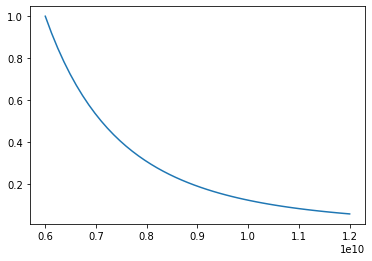

In [18]:
dist_curve = sample_from_distribution(3, 0.5, 1, 0.1, 1.0)

plt.plot(frequencies,dist_curve)


0.895797427131383
[3.  0.5 8.4 0.5 0.1]


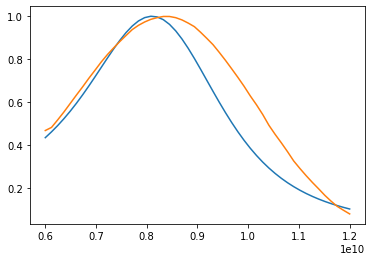

0.9558204090247956
[3.15 0.5  8.4  0.5  0.1 ]


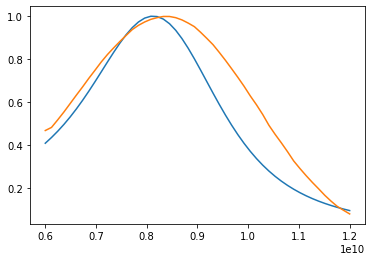

0.8982394835581247
[3.    0.525 8.4   0.5   0.1  ]


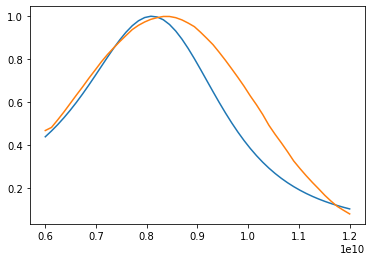

0.5565688461682736
[3.   0.5  8.82 0.5  0.1 ]


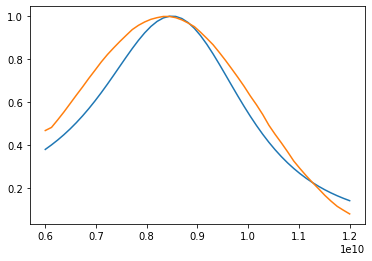

0.8882291742844503
[3.    0.5   8.4   0.525 0.1  ]


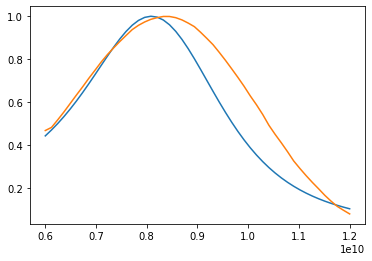

0.9110945386782082
[3.    0.5   8.4   0.5   0.105]


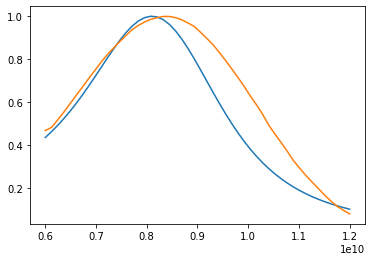

0.6147583106244799
[2.85  0.51  8.568 0.51  0.102]


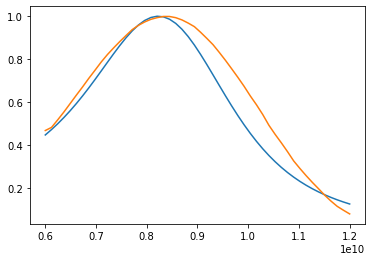

0.5753424711920202
[2.94   0.514  8.6352 0.514  0.0958]


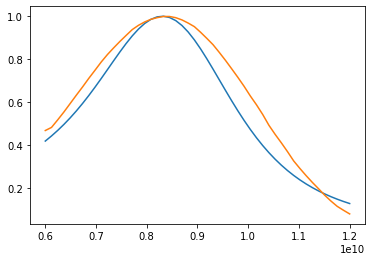

KeyboardInterrupt: 

In [33]:
def cost_function(x):
    mean_Q, sigma_Q, mean_resonant_freq, sigma_resonant_freq, cov_Q_res = x
    dist_curve = sample_from_distribution(mean_Q, sigma_Q, mean_resonant_freq, sigma_resonant_freq, cov_Q_res)

    diff = dist_curve-interp_Yang_curve
    print(np.linalg.norm(diff))
    print(x)
    plt.plot(frequencies, dist_curve)
    plt.plot(frequencies, interp_Yang_curve)
    plt.show()
    return np.linalg.norm(diff)

# gradient_iterations=10

bounds = [(1.5,4), (0.001,1), (6,14), (0.0001, 2), (0.005,2.0)]


minimizer_kwargs = dict(method="Nelder-Mead", bounds=bounds, options={"maxiter":50})

# stochastic_iterations=10 

initial_guess = [3, 0.5, 8.4, 0.5, 0.1]


# scipy.optimize.anneal

# ideal_values = minimize(cost_function, initial_guess, bounds=bounds)["x"]


tubthumper = basinhopping
ideal_values = tubthumper(cost_function, initial_guess, minimizer_kwargs=minimizer_kwargs)["x"]
#
# you may not like it, but this is the ideal

print(ideal_values)



/home/arthurdent/Programs/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.


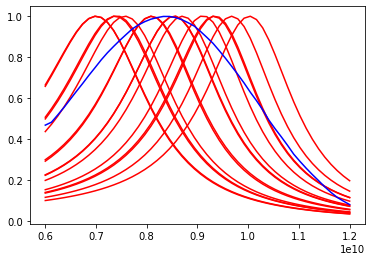

0.16102274374326522
[3.73606998, 0.73800352, 8.60690376, 1.07382641, 1.0011734]


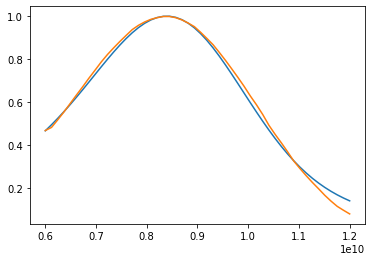

0.16102274374326522

In [61]:
cost_function([3.73606998, 0.73800352, 8.60690376, 1.07382641, 1.0011734])